*Unit 4, Sprint 2, Module 4*

---

# Neural Network Frameworks (Prepare)

## Learning Objectives
* <a href="#p1">Part 1</a>: Implemenent Regularization Strategies
* <a href="#p2">Part 2</a>: Deploy a Keras Model
* <a href="#p3">Part 3</a>: Write a Custom Callback Function (Optional)

Today's class will also focus heavily on Callback objects. We will use a variety of callbacks to monitor and manipulate our models based on data that our model produces at the end of an epoch.

> A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc). -- [Keras Documentation](https://keras.io/api/callbacks/)

# 1. Regularization Strategies (Learn)


## Overview

###Neural Networks are highly parameterized models and can be easily overfit to the training data.###

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Regularization.svg/1920px-Regularization.svg.png" width=600></center>



###When the model is overfitting, the training error (loss) continues to decrease with each epoch <br>while the test error begins to increase.###

<center><img src="https://hackernoon.com/hn-images/1*vuZxFMi5fODz2OEcpG-S1g.png" width=80000></center>

###The most salient way to combat this problem is with regularization strategies.###

There are several common ways of regularization in neural networks which we cover briefly. Here's a quick summary:

1. Always use EarlyStopping. This strategy will prevent parameters from being fitted too closely to the training data.
2. Use Weight Decay
3. Use Weight Constraint
4. Weight Constraint together with Dropout

Weight Decay and Weight Constraint accomplish similar purposes - preventing model overfitting by "regularizing" the values of the weights. The mechanics are just slightly different. Use one or the other, but not both.

### Imports we'll need

In [ ]:
%load_ext tensorboard
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Follow Along

For our experiments, we'll use the [Fashion MNIST data set](https://www.tensorflow.org/datasets/catalog/fashion_mnist), available from from tensorflow datasets. Fashion MNIST, a twist on the familiar MNIST set, consists of $28\times 28$ images of $10$ classes of Fashion items, such as shoes, purses, shirts, etc.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

# load our dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

3


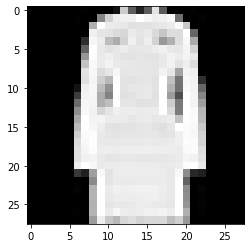

In [ ]:
image_id = 500
plt.imshow(X_train[image_id],cmap='gray');
print(y_train[image_id])

In [ ]:
# normalize pixel values between 0 and 1
max_pixel_value = 255
X_train, X_test = X_train / max_pixel_value, X_test / max_pixel_value

In [ ]:
X_train.min(), X_train.max()

(0.0, 1.0)

10 unique y values, corresponding to 10 different classes of fashion items

In [ ]:
print(np.unique(y_train))
y_train[:10]

[0 1 2 3 4 5 6 7 8 9]


array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

##1.1  Early Stopping Callback

### 1.1.1 Build and train a Neural Network on the Fashion MNIST data set
Without the `EarlyStopping` callback

Note: since the target classes are represented as integer indexes, use the  `sparse_categorical_cross_entropy` loss function. <br>
We would use `categorical_cross_entropy` if the target labels were one-hot encoded.

In [ ]:
# Clear any logs from previous runs for tensorboard
!rm -rf ./logs/

In [ ]:
%%time
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import ReLU
import tensorflow as tf
import os

# 1) Create 2 dir for logging files
# create 2 dir -- one for tensorboard results and one for early stopping
logdir = os.path.join('logs', 'Default-No-Callbacks')

# 2) Instantiate the callbacks
# instantiate a tensorboard callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 3) Build the model architecture
model = Sequential([
  Flatten(input_shape=(28,28)),
  Dense(128, activation='relu'),
  Dense(128, activation='relu'),
  Dense(128, activation='relu'),
  Dense(10, activation='softmax'),
])

# compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
         epochs=30,
         validation_data=(X_test, y_test),
         verbose=1,
         callbacks=[tensorboard_callback]) # not using the early stopping callback

In [ ]:
%tensorboard --logdir logs

### 1.1.2 Build and train a Neural Network on Fashion MNIST data set
With the `EarlyStopping` callback

In [ ]:
%%time
from tensorflow.keras.callbacks import EarlyStopping

# 1) Create 2 dir for logging files
# create 2 dir -- one for tensorboard results and one for early stopping
logdir = os.path.join('logs', 'EarlyStopping')

# 2) Instantiate the callbacks
# instantiate a tensorboard callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 2a) Add early stopping callback
stop = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=2, verbose=0,
    mode='auto', restore_best_weights=True
)

# 3) Build the model architecture
model = Sequential([
  Flatten(input_shape=(28,28)),
  Dense(128, activation='relu'),
  Dense(128, activation='relu'),
  Dense(128, activation='relu'),
  Dense(10, activation='softmax'),
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
model.fit(X_train, y_train,
         epochs=99,
         validation_data=(X_test, y_test),
         verbose=1,
         callbacks=[tensorboard_callback, stop]) # include early stopping callback

In [ ]:
%tensorboard --logdir logs

---

## 1.2 L1 and L2 regularization (Weight Decay)


These forms of regularization explicitly prevent the model from fitting the data too closely, <br>
by imposing constraints that tend to drive down the values of the parameters, hence the term "weight decay".<br>
They work by adding a term to the loss function to create a modified loss function. <br>
The model then tries to minimize the modified loss function instead of the original loss function.<br>

For L2 regularization, the modified loss function is the original loss function <br>plus a constant times the sum of the _squares_ of all the parameters:<br><br>

$J_2(\theta) = J(\theta) + C\sum_{i=1}^{N} \theta_i^2$,<br><br>
where $\theta$ is a parameter (i.e. a weight or bias), $C$ is the regularization <br>
constant (a hyperparameter) and $N$ is the number of parameters in the model.<br>

For L1 regularization, the modified loss function is the original loss function <br>plus a constant times the sum of the _absolute values_ of all the parameters:<br><br>
$J_1(\theta) = J(\theta) + C\sum_{i=1}^{N} |\theta_i|$


![](https://qph.fs.quoracdn.net/main-qimg-9d0dbf8074761b541ba80543ddfc9f73.webp)

The above images show how the minimum of the modified loss function (red dots) <br>
differs from the minimum of the original loss function (black dots).

1. The X and Y axes represent possible values for model weights, in the case of this visualization the X and Y axes represent w1 and w2 respectively
1. The elliptical contours represent the original loss function (error) surface, with the black dot representing the values of the weights that minimize the loss function.
1. The blue shapes represent the weight constraints (the diamond shape for L1, and the circle shape for L2)
1. The red dot represents the point of contact between the loss function contours and the weight constraints, where the modified loss function has a minimum.
1. The distance metric determines the geometry of the blue shapes. The L1-norm determines the diamond shape and the L2-norm determines the circular shape.
1. The norm of the weights determines where the point of contact will occur. And the norm of the weights is determined by which metric space **p** we are getting the norm equation from.

$L_p$ norm:
$${ \left\|x\right\|_{p}=\left(|x_{1}|^{p}+|x_{2}|^{p}+\dotsb +|x_{n}|^{p}\right)^{1/p}}$$  

$L_1$ norm (p = 1):
$${ \left\|x\right\|_{1}=\left(|x_{1}|+|x_{2}|+\dotsb +|x_{n}|\right)}$$

$L_2$ norm (p = 2):
$${ \left\|x\right\|_{2}=\left(|x_{1}|^{2}+|x_{2}|^{2}+\dotsb +|x_{n}|^{2}\right)^{1/2}}$$

### 1.2.1 $\textbf{L1}$ vs. $\textbf{L2}$ Regularization

1. "Ridge" ($\textbf{L2}$) and "Lasso" ($\textbf{L1}$) are two out of possibly infinitely many ways to regularize a model by using a distance metric in [$\text{Lp}$ space](https://en.wikipedia.org/wiki/Lp_space)

2. Both $\textbf{L1}$ and $\textbf{L2}$ are used to help prevent overfitting.

3. **Key difference** between $\textbf{L1}$ and $\textbf{L2}$
* $\textbf{L1}$ tends to drive some feature weights to zero (i.e. $w = 0$) effectively eliminating those features. So a side effect of $\textbf{L1}$ is *dimensionality reduction*! This happens because redundant information is encoded in that subset of features. Mathematically, this situation is refered to as [**MultiCollinearity**](https://en.wikipedia.org/wiki/Multicollinearity).
* $\textbf{L2}$ will shrink the values of all feature weights but almost never down to zero.

Check out this article for more insight [Visualizing regularization and the L1 and L2 norms](https://towardsdatascience.com/visualizing-regularization-and-the-l1-and-l2-norms-d962aa769932)



![](https://i.stack.imgur.com/4KSgs.png)

The above image shows us the geometry of 4 specific Lp spaces.

### 1.2.2 Build a Neural Net using  $L2$ regularization

In [ ]:
%%time
from tensorflow.keras import regularizers

# 1) Create 2 dir for logging files
# create 2 dir -- one for tensorboard results and one for early stopping
logdir = os.path.join('logs', 'Weight-Decay-Plus-EarlyStopping')

# 2) Instantiate the callbacks
# instantiate a tensorboard callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 2a) Add early stopping callback
stop = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=2, verbose=0,
    mode='auto', restore_best_weights=True
)

# 3) Build the model architecture
# 3a) Add regularization to model architecture
model = Sequential([
  Flatten(input_shape=(28,28)),
  Dense(128, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
  Dense(128, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
  Dense(128, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
  Dense(10, activation='softmax'),
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
model.fit(X_train, y_train,
         epochs=99,
         validation_data=(X_test, y_test),
         verbose=1,
         callbacks=[tensorboard_callback, stop])

In [ ]:
model.summary()

In [ ]:
%tensorboard --logdir logs

----

###1.3 Regularization via the `MaxNorm` Weight Constraint
In this method, after each weight vector update, we compare the norm of the updated weight vector with a user specified value of `MaxNorm`. If the norm of the updated weight vector exceeds `MaxNorm`, we scale the weight vector by a factor that clips its norm back to `MaxNorm` <br>

**Stretch Question**: How would you implement a function to apply `MaxNorm` in code?<br>
I.e. given a vector $\textbf{w}$, an update vector $\textbf{dw}$, and the value of `max_norm`, can you write a function that returns the updated weight vector $\textbf{w}_{clipped}$ with the `MaxNorm` weight constraint applied?

`MaxNorm` has been found to be quite effective when used in combination with  **Dropout Regularization**, which we discuss in the next section.

```python
tf.keras.constraints.MaxNorm(
    max_value=2, axis=0
)
```

### Exercise: <br>
Modify the above code cell for L2 regularization with option to use MaxNorm regularization instead of L2 regularization. <br>
To do this we need to instantiate MaxNorm and pass it into the layers as a `kernel_constraint`. See keras docs. <br>
Run the model. How do the results differ from the results L2 regularization?<br>


In [ ]:
from tensorflow.keras.constraints import MaxNorm

# 1) Create 2 dir for logging files
# create 2 dir -- one for tensorboard results and one for early stopping
logdir = os.path.join('logs', 'MaxNorm-Plus-EarlyStopping')

# 2) Instantiate the callbacks
# instantiate a tensorboard callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 2a) Add early stopping callback
stop = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=2, verbose=0,
    mode='auto', restore_best_weights=True
)

# 3) Build the model architecture
# 3a) Add MaxNorm weight constraint to model architecture
model = Sequential([
  Flatten(input_shape=(28,28)),
  Dense(128, kernel_constraint=MaxNorm(3), activation='relu'),
  Dense(128, kernel_constraint=MaxNorm(3), activation='relu'),
  Dense(128, kernel_constraint=MaxNorm(3), activation='relu'),
  Dense(10, activation='softmax'),
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
model.fit(X_train, y_train,
         epochs=99,
         validation_data=(X_test, y_test),
         verbose=1,
         callbacks=[tensorboard_callback, stop])

In [ ]:
%tensorboard --logdir logs

-----
##1.4  Dropout Regularization

![](https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png)

Dropout Regularization is a powerful and ingenious idea for controlling overfitting in neural networks. It is one of the key "must-know" techniques involved in building neural networks.

Geoffrey Hinton, one of the inventors of Dropout, recorded an 8-minute lecture [Dropout: an efficient way to combine neural nets](https://youtu.be/vAVOY8frLlQ) as part of his Neural Networks for Machine Learning course on Coursera. At $06:36$ in the video, Hinton explains how he came up with the idea for Dropout.

You are encouraged to skim through the original publication [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://paperswithcode.com/method/dropout), by Nitish Srivastava et al. (2014)<br>
Don't expect to understand everything, but don't let that stop you. You will be pleasantly surprised that you can understand enough to get the gist of the dropout method!

Here is the abstract:<br>
**Dropout: A Simple Way to Prevent Neural Networks from Overfitting**

Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov; 15(56):1929−1958, 2014.
Abstract

_Deep neural nets with a large number of parameters are very powerful machine learning systems. However, overfitting is a serious problem in such networks. Large networks are also slow to use, making it difficult to deal with overfitting by combining the predictions of many different large neural nets at test time. Dropout is a technique for addressing this problem. The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. During training, dropout samples from an exponential number of different thinned networks. At test time, it is easy to approximate the effect of averaging the predictions of all these thinned networks by simply using a single unthinned network that has smaller weights. This significantly reduces overfitting and gives major improvements over other regularization methods. We show that dropout improves the performance of neural networks on supervised learning tasks in vision, speech recognition, document classification and computational biology, obtaining state-of-the-art results on many benchmark data sets._


**Key Take aways:**

1. During training, dropout will probabilistically "turn off" some neurons in the layer that dropout is implemented in.
2. During inference (ie. making predictions on the test set) all neurons are used (i.e. no dropout is applied).
3. Dropout works best when used with MaxNorm weight regularization

Here are some excerpts from the dropout article.

"Dropout can be interpreted as a way of regularizing a neural network by adding noise to its hidden units." (page 2)

"Combining several models [model ensembles] is most
helpful when the individual models are different from each other and in order to make
neural net models different, they should either have different architectures or be trained
on different data...It prevents overfitting and
provides a way of approximately combining exponentially many different neural network
architectures efficiently." (page 2)

"One particular form of regularization was found to be especially useful for dropout --
constraining the norm of the incoming weight vector at each hidden unit to be upper
bounded by a
fixed constant $\text{c}$. In other words, if $\textbf{w}$ represents the vector of weights incident
on any hidden unit, the neural network was optimized under the constraint $||\textbf{w}||_{2} ≤ \text{c}$. This
constraint was imposed during optimization by projecting $\textbf{w}$ onto the surface of a ball of
radius $\text{c}$, whenever $\textbf{w}$ went out of it. This is also called **max-norm regularization** since it
implies that the maximum value that the norm of any weight can take is $\text{c}$.  The constant $\text{c}$ is a tunable hyperparameter, which is determined using a validation set." (page 6)


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm

# 1) Create 2 dir for logging files
# create 2 dir -- one for tensorboard results and one for early stopping
logdir = os.path.join('logs', 'MaxNorm-Plus-Dropout-and-EarlyStopping')

# 2) Instantiate the callbacks
# instantiate a tensorboard callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 2a) Add early stopping callback
stop = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=2, verbose=0,
    mode='auto', restore_best_weights=True
)

# 3) Build the model architecture
# 3a) Add MaxNorm weight contraint to model architecture
# 3b) Add Dropout to model architecture
model = Sequential([
  Flatten(input_shape=(28,28)),
  Dense(128, kernel_constraint=MaxNorm(3), activation='relu'),
  Dropout(0.4),
  Dense(128, kernel_constraint=MaxNorm(3), activation='relu'),
  Dropout(0.4),
  Dense(128, kernel_constraint=MaxNorm(3), activation='relu'),
  Dropout(0.4),
  Dense(10, activation='softmax'),
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
model.fit(X_train, y_train,
         epochs=99,
         validation_data=(X_test, y_test),
         verbose=1,
         callbacks=[tensorboard_callback, stop])

In [ ]:
%tensorboard --logdir logs

## Challenge

You will apply regularization strategies inside your neural network today, as you try to avoid overfitting it.

---

# 2. Deploy (Learn)

## Overview

You've built a nice image classification model, but it's just sitting your Jupyter Notebook. What now? <br>
Well you can deploy to some down stream application. TensorFlow supports three ways of deploying its models:

- In-Browser with `TensorFlow.js`
- API with TensorFlow Serving (TFX) or another Framework
- On-Device with TensorFlow Lite

You are already familiar with deploying a model as an API from Unit 3, so we will focus on deploying a model in browser. Both methods rely on the same core idea: save your weights and architecture information, load those parameters into application, and perform inference.



## Follow Along

### ModelCheckpoint callback

`save_weights_only = True` means the weights and biases are saved at the end of each epoch<br>
`save_weights_only = False` means the model architecture is saved in addition to the weights and biases.

In [ ]:
%%time
import tensorflow as tf

# set up checkpoint callback
checkpoint_filepath = "./weights_best.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

def create_model():

    model = tf.keras.Sequential([
          Flatten(input_shape=(28,28)),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(10, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

    return model

model = create_model()

model.fit(X_train, y_train,
          epochs=3,
          validation_data=(X_test,y_test),
          verbose=2,
          callbacks=[checkpoint_callback])

Evaluate the model on the test data

In [ ]:
model.evaluate(X_test, y_test)

Check that instantiating an empty model followed by loading the previously<br>
saved weights and then training the model recovers the same result!

In [ ]:
# create a fresh version of the compiled model
new_model = create_model()

# load the saved weights
new_model.load_weights(checkpoint_filepath)
new_model.summary()

In [ ]:
# Verify that evaluating the model using the saved weights gives the same result as before
new_model.evaluate(X_test, y_test)

### Save Entire Model
This time we'll save the model architecture as well as the weights & biases

In [ ]:
%%time
import tensorflow as tf

# set up checkpoint callback
checkpoint_filepath = "./weights_best.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=False)

# build and compile the model
model = create_model()

# fit the model
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_test,y_test),
          verbose=2,
          callbacks=[checkpoint_callback])

In [ ]:
# evalute model
model.evaluate(X_test, y_test)

Load the saved model and check that we recover the original result using the saved weights

In [ ]:
# Load the saved model and the weights and biases
saved_model = tf.keras.models.load_model(checkpoint_filepath)

# Check that we retrieved the saved model architecture correctly
saved_model.summary()

# check that we get the original result using the saved weights
saved_model.evaluate(X_test, y_test)

### Alternate way to save the model, "manually"

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
# Load the saved model and the weights and biases
saved_model = tf.keras.models.load_model('saved_model/my_model')

# Check that we retrieved the saved model architecture correctly
saved_model.summary()

# check that we get the original result using the saved weights
saved_model.evaluate(X_test, y_test)

How to access the weights and biases from your model

In [ ]:
wts = saved_model.weights
print(len(wts))

In [ ]:
# Weights contain the weights and biases for each layer
#   weights arranged in 2-D arrays, one column for each neuron
#   biases for the layer come next in a vector

for index in range(8):
  print(wts[index].shape)

In [ ]:
wts[7]

## Challenge

You will be expected to be able to export your model weights and architecture on the assignment.

# 3. Custom Callbacks (Stretch)

## Overview

Custom callbacks all you to access data at any point during the training: on batch end, on epoch end, on epoch start, on batch start. Our use case today is a simple one. Let's stop training once we reach a benchmark accuracy.

## Follow Along
Review Tensorflow's [Guide to custom callbacks]( https://www.tensorflow.org/guide/keras/custom_callback), then try implementing some simple callbacks of your choice!

In [ ]:
import matplotlib
# Specifying the backend to be used before importing pyplot
# to avoid "RuntimeError: Invalid DISPLAY variable"
matplotlib.use('agg')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

class CustomTrainingPlotCallback(tf.keras.callbacks.Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):

        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))

    # This function is called at the end of training
    def on_train_end(self, epoch, logs={}):

        # Get number of epochs
        N = np.arange(0, len(self.losses))

        # You can chose the style of your preference
        plt.style.use("seaborn")

        # Plot train loss, train acc, val loss and val acc against epochs passed
        plt.figure()
        plt.plot(N, self.acc, label = "train_acc")
        plt.plot(N, self.val_acc, label = "val_acc")
        plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.savefig('./Training-and-Validation-Performance.png')
        plt.show()

stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

model = tf.keras.Sequential([
      Flatten(input_shape=(28,28)),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=20,
          validation_data=(X_test,y_test),
          callbacks=[CustomTrainingPlotCallback(), stop])

## Challenge

Experiment with improving our custom callback function.

## (Bonus) Deploy a Simple Interactive Application

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# normalize data
max_pixel_value = 255
X_train = X_train / max_pixel_value
X_test = X_test / max_pixel_value

X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
  Dense(64, activation='relu', input_dim=784),
  Dense(32, activation='relu'),
  Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test))

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.math import top_k

def sketch_recognition(img):
  img_reshaped = img.reshape((1, 784))
  prediction = model.predict(img_reshaped)
  result = top_k(prediction, k=5)
  pred_labels = result.indices.numpy()
  pred_probs = result.values.numpy()
  return dict(zip(pred_labels.tolist()[0], pred_probs.tolist()[0]))

label = gr.outputs.Label(num_top_classes=5)

gr.Interface(fn=sketch_recognition,
             inputs="sketchpad",
             outputs=label).launch(debug=True)